In [1]:
cd /content/drive/My Drive/Studier/Master/Master Thesis/Coding/

/content/drive/My Drive/Studier/Master/Master Thesis/Coding


Device type: cuda:0
Loading settings from: ./c-LSTM-LM/settings/settings.txt
Loading data and creating word and syllable vocabularies.
Currently loading data from: sub_folder1
Number of corrupted files in subfolder: 0
Currently loading data from: sub_folder2


------ Parameters -----
   settings_file:  settings.txt
         verbose:  1
            data:  ./dataset_creation/augmented_dataset3_sorted
      checkpoint:  ./c-LSTM-LM/checkpoint_18052020_1600/
          window:  10
       word_size:  20000
        word_dim:  512
      melody_dim:  256
            seed:  0
     num_workers:  4
      num_epochs:  100
      batch_size:  32
              lr:  0.001
    log_interval:  5
   save_interval:  5
      train_rate:  0.8
        val_rate:  0.2
       test_rate:  0
      num_layers:  3


Number of corrupted files in subfolder: 0
Total number of corrupted files = 0
Number of unique words: 2739
Creating word embeddings
Currently loading data from: sub_folder1
Currently loading data from: sub_folder2


------ Data Stats -----
Number of songs:  200
  vocab size:  2743
feature size:  283
syllable size:  16


Training set:  160  songs, Validation set:  20  songs, Test set:  20  songs.
model_summary

Layer_name							Number of Parameters
										

Embedding(2743, 512)			1476864

Linear(in_features=283, out_features=256, bias=True)			256

LSTM(768, 768, num_layers=3, batch_first=True)			2359296

Linear(in_features=768, out_features=2743, bias=True)			2359296

Linear(in_features=768, out_features=16, bias=True)			3072

ReLU(inplace=True)			2362368

BatchNorm1d(2743, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)			2359296

BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)			3072
Total Params:10923520
Number of parameters:  17778517


------ Training -----
| Training Epoch:   1/100       0/     5 | lr:0.00100 |    0.80 s/batch | 354.58 ms/data_load | Loss(Syllable) 3.06735 | Loss(Lyrics) 8.25021 |



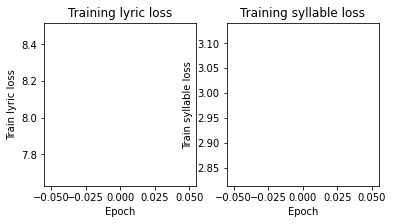

<Figure size 432x288 with 0 Axes>

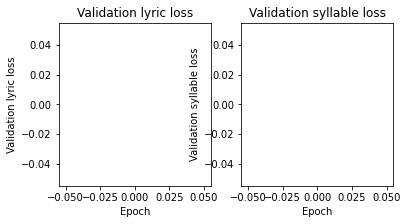

-----------
| Training Epoch:   2/100       0/     5 | lr:0.00100 |    0.62 s/batch | 323.76 ms/data_load | Loss(Syllable) 2.79305 | Loss(Lyrics) 7.67858 |



<Figure size 432x288 with 0 Axes>

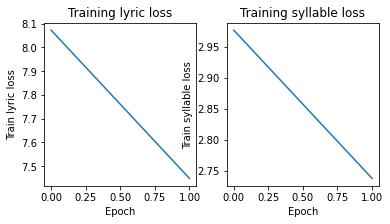

<Figure size 432x288 with 0 Axes>

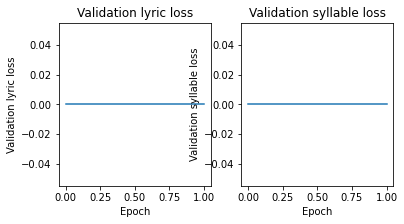

-----------


KeyboardInterrupt: ignored

In [2]:
# Train
%run ./c-LSTM-LM/train.py